In [4]:
# mount google drive to access/load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Input, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the dataset
def load_data(file_path):
    articles = []
    summaries = []
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            # First join words in each sentence, then join sentences in each paragraph
            article_text = ' '.join([' '.join(sentence) for paragraph in data['paragraphs'] for sentence in paragraph])
            summary_text = ' '.join([' '.join(sentence) for sentence in data['summary']])
            articles.append(article_text)
            summaries.append(summary_text)
    return articles, summaries


# Paths to one of the dataset's JSONL files (adjust for different folds)
train_file = 'dataset/indosum/train.01.jsonl'
dev_file = 'dataset/indosum/dev.01.jsonl'
test_file = 'dataset/indosum/test.01.jsonl'

# Load data
train_articles, train_summaries = load_data(train_file)
dev_articles, dev_summaries = load_data(dev_file)
test_articles, test_summaries = load_data(test_file)

In [6]:
print(f"jumlah data : {len(train_articles)}")
print(f"contoh artikel : {train_articles[0]}")
print(f"contoh summary artikel : {train_summaries[0]}")

jumlah data : 14262
contoh artikel : Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu . Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat . " Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) . Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga ta

In [ ]:
# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_articles + train_summaries)

# Convert texts to sequences
def texts_to_sequences(texts, max_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Set max sequence lengths
max_article_len = 500
max_summary_len = 100

# Convert articles and summaries to sequences
X_train = texts_to_sequences(train_articles, max_length=max_article_len)
Y_train = texts_to_sequences(train_summaries, max_length=max_summary_len)
X_dev = texts_to_sequences(dev_articles, max_length=max_article_len)
Y_dev = texts_to_sequences(dev_summaries, max_length=max_summary_len)

In [ ]:
# Define the model
embedding_dim = 128
rnn_units = 256
vocab_size = len(tokenizer.word_index) + 1

# Encoder
encoder_inputs = Input(shape=(max_article_len,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = Bidirectional(SimpleRNN(rnn_units, return_sequences=False))(encoder_embedding)
encoder_output = Dense(rnn_units)(encoder_rnn)

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_rnn = SimpleRNN(rnn_units, return_sequences=True)(decoder_embedding, initial_state=[encoder_output])
decoder_outputs = Dense(vocab_size, activation='softmax')(decoder_rnn)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 128)       │     12,122,752 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512)            │        197,120 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 128)       │     12,122,752 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_1 (SimpleRNN)  │ (None, 100, 256)       │         98,560 │ embedding_1[0][0],     │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 94709)     │     24,340,213 │ simple_rnn_1[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,012,725 (186.97 MB)

 Trainable params: 49,012,725 (186.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare decoder input/output for training
Y_train_in = np.insert(Y_train, 0, 0, axis=1)[:, :-1]  # Shifted target sequences
Y_train_out = np.expand_dims(Y_train, -1)

# Training
batch_size = 64

In [ ]:
history = model.fit([X_train, Y_train_in], Y_train_out, batch_size=batch_size, epochs=10, validation_data=([X_dev, Y_dev], np.expand_dims(Y_dev, -1)))

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 128s 542ms/step - accuracy: 0.3911 - loss: 6.9018 - val_accuracy: 0.4268 - val_loss: 4.8973
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 118s 527ms/step - accuracy: 0.4084 - loss: 4.9196 - val_accuracy: 0.4173 - val_loss: 4.9182
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 119s 531ms/step - accuracy: 0.4191 - loss: 4.6344 - val_accuracy: 0.4152 - val_loss: 4.8764
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 532ms/step - accuracy: 0.4374 - loss: 4.2631 - val_accuracy: 0.4156 - val_loss: 4.8607
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 533ms/step - accuracy: 0.4514 - loss: 3.9927 - val_accuracy: 0.4172 - val_loss: 4.8484
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 534ms/step - accuracy: 0.4647 - loss: 3.7657 - val_accuracy: 0.4170 - val_loss: 4.8595
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 534ms/step - accuracy: 0.4744 - loss: 3.5985 - val_accuracy: 0.4175 - val_loss: 4.8737
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 536ms/step - accuracy: 0.4826 -

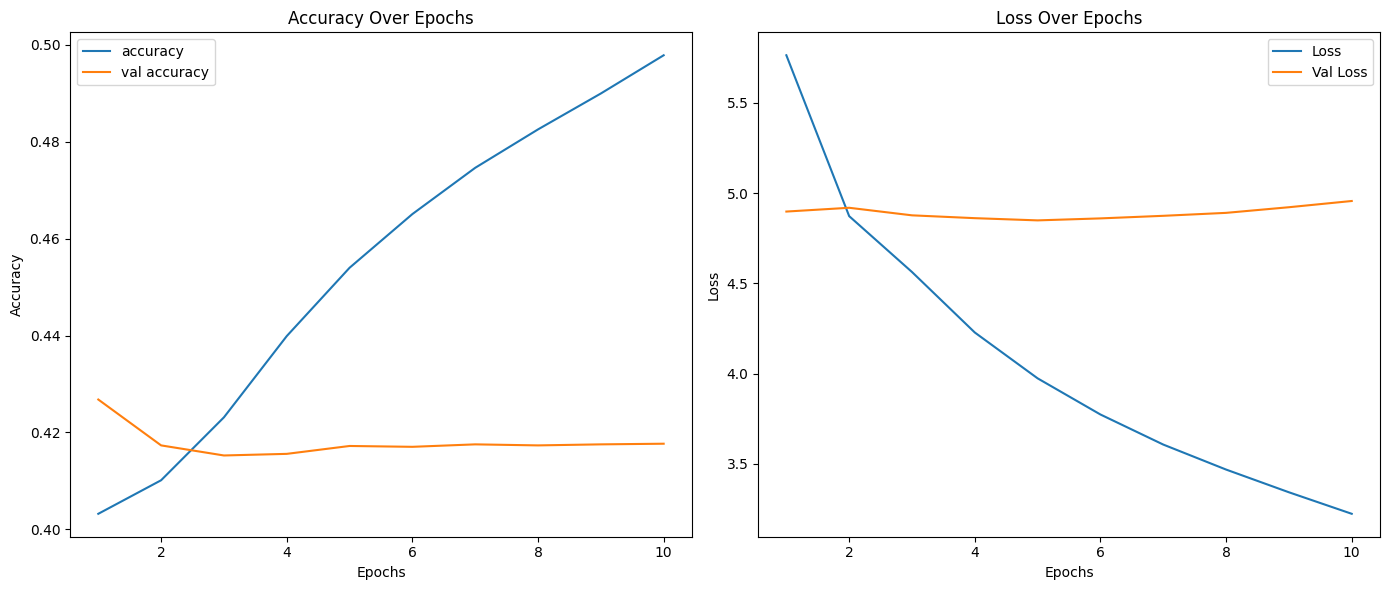

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Summary generation function
def generate_summary(article_seq, model):
    article_seq = pad_sequences([article_seq], maxlen=max_article_len, padding='post')
    summary_seq = [0]  # Start token

    for _ in range(max_summary_len):
        # Predict next token
        output = model.predict([article_seq, pad_sequences([summary_seq], maxlen=max_summary_len, padding='post')])
        next_token = np.argmax(output[0, len(summary_seq) - 1, :])

        # Debug: Print the predicted token
        print(f"Predicted token: {next_token}, word: {tokenizer.index_word.get(next_token, '')}")

        # If the predicted token is the end-of-sequence or padding token, stop
        if next_token == 0:
            break
        summary_seq.append(next_token)

    return ' '.join(tokenizer.index_word.get(i, '') for i in summary_seq[1:])


# Convert test articles and summaries to sequences
X_test = texts_to_sequences(test_articles, max_length=max_article_len)
Y_test = texts_to_sequences(test_summaries, max_length=max_summary_len)

In [ ]:
# Example: generate summary for a test article
example_article_seq = X_test[0]
generated_summary = generate_summary(example_article_seq, model)
print(f"Original Article: {test_articles[0]}")
print("Generated Summary:", generated_summary)
print("Reference Summary:", ' '.join([tokenizer.index_word.get(i, '') for i in Y_test[0] if i != 0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
Predicted token: 28, word:  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted token: 225, word: menteri
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted token: 1942, word: koordinator
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted token: 514, word: bidang
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted token: 8643, word: kemaritiman
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted token: 5716, word: luhut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted token: 12611, word: binsar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted token: 6488, word: panjaitan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted token: 57, word: mengatakan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted token: 51, word: bahwa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted token: 488, word: pihaknya
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted token: 11, word: akan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted token: 415, word: segera
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

In [ ]:
# Encoder
encoder2_inputs = Input(shape=(max_article_len,))
encoder2_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder2_inputs)
encoder2_rnn = SimpleRNN(rnn_units, return_sequences=False)(encoder2_embedding)
encoder2_output = Dense(rnn_units)(encoder2_rnn)

# Decoder
decoder2_inputs = Input(shape=(max_summary_len,))
decoder2_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder2_inputs)
decoder2_rnn = SimpleRNN(rnn_units, return_sequences=True)(decoder2_embedding, initial_state=[encoder2_output])
decoder2_outputs = Dense(vocab_size, activation='softmax')(decoder2_rnn)

# Define the model
model2 = Model([encoder2_inputs, decoder2_inputs], decoder2_outputs)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 500, 128)       │     12,122,752 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_2 (SimpleRNN)  │ (None, 256)            │         98,560 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 100, 128)       │     12,122,752 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ simple_rnn_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_3 (SimpleRNN)  │ (None, 100, 256)       │         98,560 │ embedding_3[0][0],     │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 100, 94709)     │     24,340,213 │ simple_rnn_3[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,848,629 (186.34 MB)

 Trainable params: 48,848,629 (186.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# history2 = model2.fit([X_train, Y_train_in], Y_train_out, batch_size=batch_size, epochs=10, validation_data=([X_dev, Y_dev], np.expand_dims(Y_dev, -1)))

In [ ]:
# accuracy = history2.history["accuracy"]
# val_accuracy = history2.history["val_accuracy"]
# loss = history2.history["loss"]
# val_loss = history2.history["val_loss"]

# epochs = range(1, len(accuracy) + 1)

# plt.figure(figsize=(14, 6))

# # Plot accuracy
# plt.subplot(1, 2, 1)
# plt.plot(epochs, accuracy, label='accuracy')
# plt.plot(epochs, val_accuracy, label='val accuracy')
# plt.title('Accuracy Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot loss
# plt.subplot(1, 2, 2)
# plt.plot(epochs, loss, label='Loss')
# plt.plot(epochs, val_loss, label='Val Loss')
# plt.title('Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# # Example: generate summary for a test article
# example_article_seq = X_test[0]
# generated_summary = generate_summary(example_article_seq, model2)
# print(f"Original Article: {test_articles[0]}")
# print("Generated Summary:", generated_summary)
# print("Reference Summary:", ' '.join([tokenizer.index_word.get(i, '') for i in Y_test[0] if i != 0]))